In [1]:
## checking gpu availability
import torch
print(torch.cuda.is_available())

True


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:02<00:00, 63953013.40it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# (a)

In [12]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [14]:
net = MLP()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



In [15]:
num_epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training
    net.train()
    running_loss = 0.0
    correct, total = 0, 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)

    # Validation
    net.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(testloader))
    val_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')


Epoch 1/20, Train Loss: 1.7076, Train Acc: 38.77%, Val Loss: 1.4897, Val Acc: 47.47%
Epoch 2/20, Train Loss: 1.4349, Train Acc: 48.93%, Val Loss: 1.4484, Val Acc: 48.59%
Epoch 3/20, Train Loss: 1.3200, Train Acc: 53.20%, Val Loss: 1.4054, Val Acc: 50.24%
Epoch 4/20, Train Loss: 1.2262, Train Acc: 56.12%, Val Loss: 1.3902, Val Acc: 51.91%
Epoch 5/20, Train Loss: 1.1491, Train Acc: 59.11%, Val Loss: 1.2988, Val Acc: 54.23%
Epoch 6/20, Train Loss: 1.0760, Train Acc: 61.61%, Val Loss: 1.3480, Val Acc: 54.02%
Epoch 7/20, Train Loss: 1.0085, Train Acc: 63.82%, Val Loss: 1.3623, Val Acc: 53.91%
Epoch 8/20, Train Loss: 0.9444, Train Acc: 66.16%, Val Loss: 1.4014, Val Acc: 53.58%
Epoch 9/20, Train Loss: 0.8842, Train Acc: 68.47%, Val Loss: 1.4684, Val Acc: 52.50%
Epoch 10/20, Train Loss: 0.8285, Train Acc: 70.32%, Val Loss: 1.4418, Val Acc: 54.62%
Epoch 11/20, Train Loss: 0.7746, Train Acc: 72.00%, Val Loss: 1.5586, Val Acc: 53.71%
Epoch 12/20, Train Loss: 0.7256, Train Acc: 73.79%, Val Loss: 1

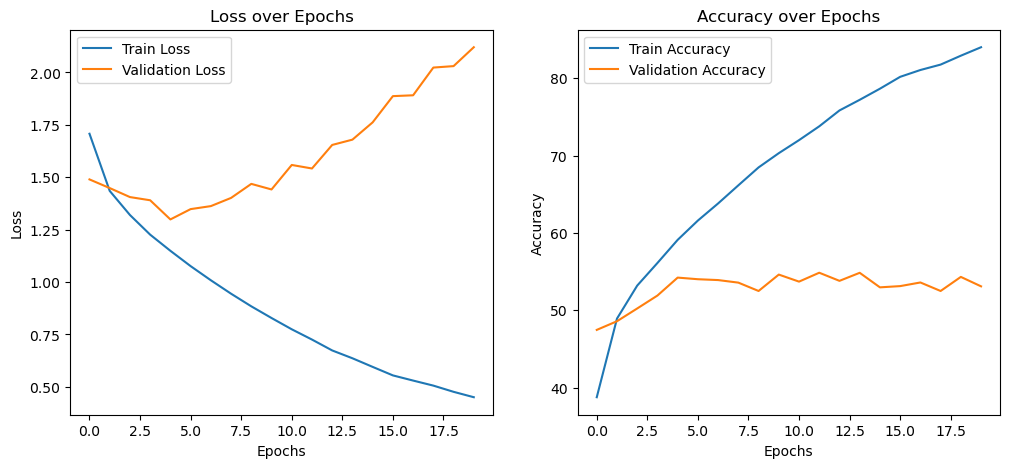

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [17]:
# Generate predictions and targets for the entire test set
all_preds = []
all_targets = []
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_targets, all_preds, target_names=classes))

# Confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
print(conf_matrix)


              precision    recall  f1-score   support

       plane       0.57      0.67      0.62      1000
         car       0.67      0.56      0.61      1000
        bird       0.49      0.36      0.41      1000
         cat       0.35      0.40      0.37      1000
        deer       0.47      0.47      0.47      1000
         dog       0.43      0.41      0.42      1000
        frog       0.57      0.59      0.58      1000
       horse       0.60      0.60      0.60      1000
        ship       0.59      0.72      0.65      1000
       truck       0.60      0.54      0.57      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.53     10000
weighted avg       0.53      0.53      0.53     10000

[[672  19  41  25  31  20  19  20 116  37]
 [ 58 555  14  33  14  15  13  18 130 150]
 [ 99  10 357 109 130  86  96  61  33  19]
 [ 33  18  60 404  70 180 108  56  38  33]
 [ 44   5  96  84 465  67 101  88  30  20]
 [ 30   9  59 239  65 413 

In [18]:
torch.save(net.state_dict(), 'cifar10_mlp_3layer_basic_model.pth')


# (b)

In [19]:
class ComplexMLP(nn.Module):
    def __init__(self):
        super(ComplexMLP, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 1024)  # Increased width
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)       # Added extra layer
        self.fc5 = nn.Linear(128, 64)        # Added extra layer
        self.fc6 = nn.Linear(64, 10)         # Output layer for 10 classes

    def forward(self, x):
        x = x.view(-1, 3*32*32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x


In [20]:
net = ComplexMLP()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [21]:
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

In [22]:
num_epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training
    net.train()
    running_loss = 0.0
    correct, total = 0, 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)

    # Validation
    net.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(testloader))
    val_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')


Epoch 1/20, Train Loss: 2.3018, Train Acc: 11.79%, Val Loss: 2.2985, Val Acc: 14.78%
Epoch 2/20, Train Loss: 2.2823, Train Acc: 16.21%, Val Loss: 2.2122, Val Acc: 16.29%
Epoch 3/20, Train Loss: 2.0358, Train Acc: 23.22%, Val Loss: 1.9075, Val Acc: 29.45%
Epoch 4/20, Train Loss: 1.8374, Train Acc: 31.83%, Val Loss: 1.7586, Val Acc: 35.34%
Epoch 5/20, Train Loss: 1.6977, Train Acc: 37.83%, Val Loss: 1.6189, Val Acc: 40.54%
Epoch 6/20, Train Loss: 1.5588, Train Acc: 43.13%, Val Loss: 1.5114, Val Acc: 45.31%
Epoch 7/20, Train Loss: 1.4571, Train Acc: 46.99%, Val Loss: 1.4697, Val Acc: 47.35%
Epoch 8/20, Train Loss: 1.3747, Train Acc: 49.87%, Val Loss: 1.4119, Val Acc: 49.38%
Epoch 9/20, Train Loss: 1.3009, Train Acc: 52.80%, Val Loss: 1.4053, Val Acc: 49.89%
Epoch 10/20, Train Loss: 1.2342, Train Acc: 55.22%, Val Loss: 1.3583, Val Acc: 52.07%
Epoch 11/20, Train Loss: 1.1714, Train Acc: 57.74%, Val Loss: 1.3830, Val Acc: 51.01%
Epoch 12/20, Train Loss: 1.1104, Train Acc: 60.07%, Val Loss: 1

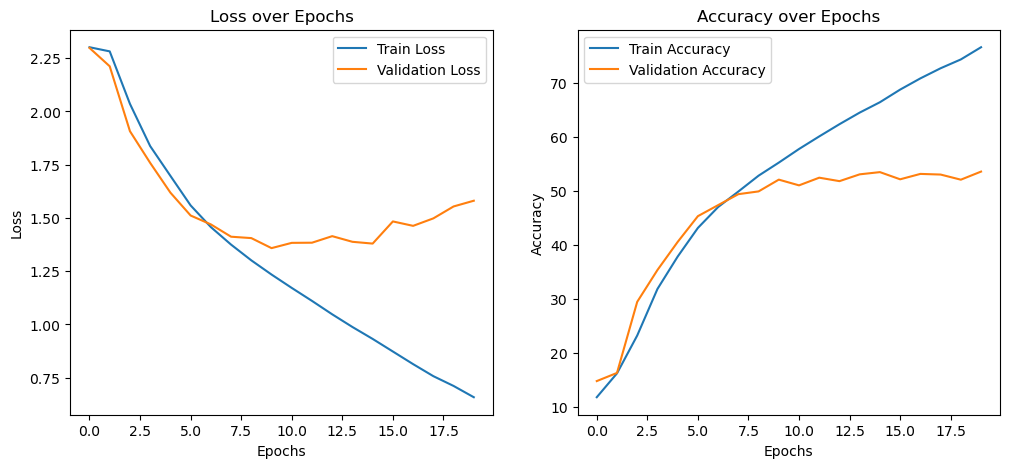

In [23]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import itertools


In [24]:
# Generate predictions and targets for the entire test set
all_preds = []
all_targets = []
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_targets, all_preds, target_names=classes))

# Confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
# print(conf_matrix)



              precision    recall  f1-score   support

       plane       0.58      0.66      0.62      1000
         car       0.65      0.63      0.64      1000
        bird       0.45      0.45      0.45      1000
         cat       0.35      0.29      0.32      1000
        deer       0.45      0.46      0.45      1000
         dog       0.46      0.45      0.46      1000
        frog       0.63      0.55      0.58      1000
       horse       0.62      0.57      0.59      1000
        ship       0.56      0.76      0.65      1000
       truck       0.59      0.54      0.56      1000

    accuracy                           0.54     10000
   macro avg       0.53      0.54      0.53     10000
weighted avg       0.53      0.54      0.53     10000

[[661  29  42  22  34   7  16   9 153  27]
 [ 59 631   8  19   8   5  11   9 108 142]
 [ 97  16 446  72 143  76  65  34  32  19]
 [ 34  25  94 287  71 228 101  74  51  35]
 [ 54  22 146  46 464  58  73  83  39  15]
 [ 18  17  80 174  78 452 

In [26]:
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


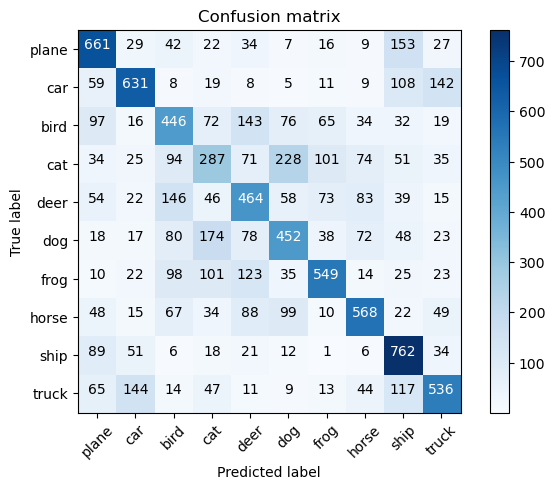

In [31]:
plot_confusion_matrix(conf_matrix, classes)  # Replace with your class names